<a href="https://colab.research.google.com/github/miguel-fc/Neutron_Reflect/blob/main/nr_v21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

Cloning into 'Neutron_Reflect'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 183 (delta 31), reused 47 (delta 12), pack-reused 106
Receiving objects: 100% (183/183), 20.96 MiB | 21.25 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [2]:
# Import Python related required packages
import io
import os
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle
import random

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
seed = 456
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
#Set these important parameters
#Dimension of the latent space 
d = 10
#Dimension of the graphs
in_d1 = 2
in_d2 = 72
#Number of epochs
num_epochs = 100
#Number of layers
num_layers = 2
#Number of neurons
num_neur=500 


In [5]:
cd Neutron_Reflect/

/content/Neutron_Reflect


In [6]:
#Stored those numpy arrays
data_path = './data/'
expt_arr = np.load(os.path.join(data_path,'mod_expt.npy'))
# expt_arr_o = np.loadtxt(os.path.join(data_path,'flipped_sorted_no_nano_expt.dat')).T
# expt_arr = np.zeros_like(expt_arr_o)
# # expt_arr[0] = 1791.5076453352374 - expt_arr_o[0]
# expt_arr[0] = expt_arr_o[0]
# expt_arr[1] = expt_arr_o[1]
sld_arr = np.load(os.path.join(data_path,'mod_sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'mod_params_fp49.npy'))
# t_sld_arr = np.load(os.path.join(data_path,'train_data.npy'))
# params_arr = np.load(os.path.join(data_path,'train_pars.npy'))

In [7]:
expt_arr.shape ,sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype, expt_arr.dtype

((2, 72),
 (5942, 2, 72),
 (5942, 3),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

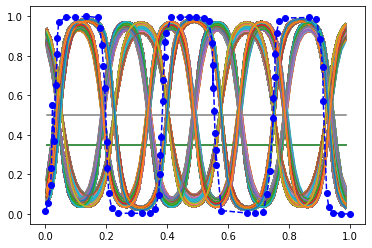

In [8]:
for x in range(sld_arr.shape[0]):
  plt.plot(sld_arr[x][0],sld_arr[x][1])
plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')

In [9]:
# #Normalize labels

# x_val=params_arr[:,0]
# x_min_expt = x_val.min()
# x_max_expt = x_val.max()
# print('x-range = ', x_min_expt, ' to ',x_max_expt)
# params_arr[:,0] = (params_arr[:,0] - x_min_expt)/(x_max_expt - x_min_expt)

# x_val=params_arr[:,1]
# x_min_expt = x_val.min()
# x_max_expt = x_val.max()
# print('x-range = ', x_min_expt, ' to ',x_max_expt)
# params_arr[:,1] = (params_arr[:,1] - x_min_expt)/(x_max_expt - x_min_expt)

# x_val=params_arr[:,2]
# x_min_expt = x_val.min()
# x_max_expt = x_val.max()
# print('x-range = ', x_min_expt, ' to ',x_max_expt)
# params_arr[:,2] = (params_arr[:,2] - x_min_expt)/(x_max_expt - x_min_expt)

In [10]:
# #Check normalization worked

# x_val=params_arr[:,0]
# x_min_expt = x_val.min()
# x_max_expt = x_val.max()
# print('x-range = ', x_min_expt, ' to ',x_max_expt)

# x_val=params_arr[:,1]
# x_min_expt = x_val.min()
# x_max_expt = x_val.max()
# print('x-range = ', x_min_expt, ' to ',x_max_expt)

# x_val=params_arr[:,2]
# x_min_expt = x_val.min()
# x_max_expt = x_val.max()
# print('x-range = ', x_min_expt, ' to ',x_max_expt)


In [11]:
#Find the flat lines in the sld plot
flat_lines_index = []
# icont = 0
for x in range(sld_arr.shape[0]):
  xmax = sld_arr[x,1,].max()
  xmin = sld_arr[x,1,].min()
  if (xmax - xmin) <= 0.001:
    # icont += 1
    flat_lines_index.append(x)

sld_files = []
for x in range(sld_arr.shape[0]):
    sld_files.append(x)   

len(sld_files), len(flat_lines_index)     

(5942, 40)

In [12]:
#Delete the flat sld lines
myslds = [sld_id for sld_id in range(len(sld_files)) if sld_id not in flat_lines_index]
len(myslds)

5902

In [13]:
n_sld_arr = sld_arr[myslds,:,:]
n_params_arr = params_arr[myslds,:]

n_sld_arr.shape, n_params_arr.shape

((5902, 2, 72), (5902, 3))

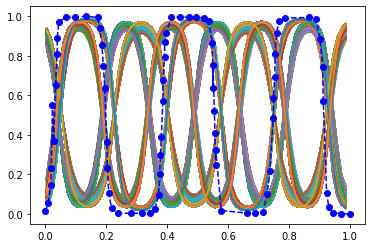

In [14]:
#Replot to make sure the flat lines are not shown
for x in range(n_sld_arr.shape[0]):
  plt.plot(n_sld_arr[x][0],n_sld_arr[x][1])
plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')

In [15]:
#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [16]:
#Prepare data files
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(n_sld_arr,n_params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4721, 2, 72) (4721, 3) (590, 2, 72) (590, 3) (591, 2, 72) (591, 3)


In [17]:
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

In [18]:
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [19]:
def initialize_model(d,in_d1,in_d2,num_layers,num_neur):
  lr= 0.001
  # torch.manual_seed(0)
  
  encoder = au.Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)
  decoder = au.Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': encoder.parameters()},
     {'params': decoder.parameters()}
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return encoder, decoder, optim

In [20]:
#Initialize autoencoder
encoder, decoder, optim = initialize_model(d,in_d1,in_d2,num_layers,num_neur)

#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = au.fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = au.val(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

EPOCH 1/100 	 train loss 0.07318402081727982 	 val loss 0.007243436761200428
EPOCH 2/100 	 train loss 0.000745259050745517 	 val loss 0.00047901246580295265
EPOCH 3/100 	 train loss 0.0002460187824908644 	 val loss 0.00020987051539123058
EPOCH 4/100 	 train loss 0.00017167002079077065 	 val loss 0.00013907729589845985
EPOCH 5/100 	 train loss 0.00013105622201692313 	 val loss 0.00011713870480889454
EPOCH 6/100 	 train loss 0.00012095609417883679 	 val loss 0.00010966565605485812
EPOCH 7/100 	 train loss 0.0001104916664189659 	 val loss 0.00011722820636350662
EPOCH 8/100 	 train loss 0.00010270311759086326 	 val loss 9.074874105863273e-05
EPOCH 9/100 	 train loss 9.36471187742427e-05 	 val loss 8.532837819075212e-05
EPOCH 10/100 	 train loss 0.00011446425196481869 	 val loss 0.00010215758084086701
EPOCH 11/100 	 train loss 8.938576502259821e-05 	 val loss 8.223047916544601e-05
EPOCH 12/100 	 train loss 0.00010580148227745667 	 val loss 0.0001506292464910075
EPOCH 13/100 	 train loss 0.0

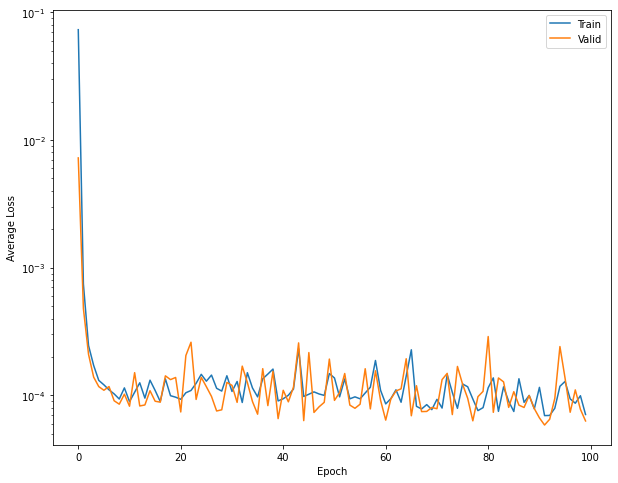

In [21]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

For image 0, the loss = 5.1593211537692696e-05
For image 1, the loss = 3.068133082706481e-05
For image 2, the loss = 7.665371958864853e-05
For image 3, the loss = 2.5362362066516653e-05
For image 4, the loss = 7.574867049697787e-05
For image 5, the loss = 3.247574204578996e-05
For image 6, the loss = 5.056227746536024e-05
For image 7, the loss = 4.7859619371593e-05
For image 8, the loss = 0.00016767560737207532
For image 9, the loss = 7.107378041837364e-05


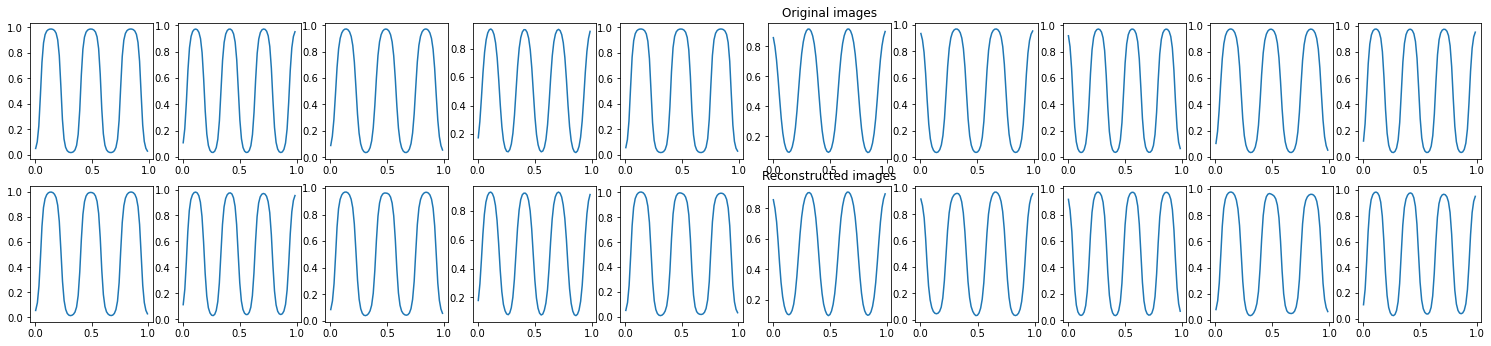

In [22]:
au.test(encoder,decoder,test_dataset,device,loss_fn,in_d1,in_d2,n=10)

In [23]:
# #Interpolating in the latent space
# #This is similar to a manifold

# def get_img_from_fig(fig, dpi=180):
#     buf = io.BytesIO()
#     fig.savefig(buf, format="png", dpi=dpi)
#     buf.seek(0)
#     img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
#     buf.close()
#     plt.close()
#     img = cv2.imdecode(img_arr,0)

#     return img

# def show_image(img):
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     ax.set_xticks([])
#     ax.set_yticks([])

# encoder.eval()
# decoder.eval()

# with torch.no_grad():
#     images, labels = iter(train_loader).next()
#     images = images.view(images.size(0), -1).to(device) 

#     latent = encoder(images)
#     latent = latent.cpu()

#     mean = latent.mean(dim=0)
#     print(mean)
#     std = (latent - mean).pow(2).mean(dim=0).sqrt()
#     print(std)


#     latent = torch.randn(200, d)*std + mean
#     latent = latent.to(device)
#     img_recon = decoder(latent)
#     img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


# n_img = []
# for i in range(img_recon.shape[0]):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.close()
#     ax.plot(img_recon[i][0],img_recon[i][1])
#     n_img.append(get_img_from_fig(fig))

# n_img = torch.from_numpy(np.asarray(n_img))
# n_img = n_img[:,np.newaxis,:,:]

# fig, ax = plt.subplots(figsize=(20, 8.5))
# show_image(torchvision.utils.make_grid(n_img[:100],10,5))
# plt.show()

In [24]:
nlabel = params_arr.shape[1]
print(nlabel)

for i in range(nlabel):
  label_index = 'label'+str(i)
  # print(label_index)

3


In [25]:
encoded_samples = []
for sample in train_dataset:
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    # print(enumerate(encoded_img))
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,label0,label1,label2
0,0.177324,-0.114617,-0.198161,0.004059,-0.051803,-0.018912,-0.168105,0.232358,0.040395,0.020883,0.134,0.362,0.1201
1,-0.630573,0.318937,-0.711697,-0.422619,1.155268,-0.685799,0.309214,-0.835317,-0.801257,1.284341,0.123,0.419,-0.37474
2,-1.337980,0.878217,0.239067,-0.587388,0.983193,-0.362008,1.712363,-1.789861,-0.517097,-0.015108,0.19,-0.019,2e-05
3,0.177281,-0.115427,-0.204380,0.003161,-0.046510,-0.022795,-0.172317,0.232590,0.036119,0.031183,0.186,0.234,0.21981
4,-0.625075,0.315491,-0.711790,-0.420235,1.150284,-0.683659,0.303338,-0.828062,-0.798223,1.282206,0.114,0.43,-0.129
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4716,-0.624815,0.330614,-0.576638,-0.400500,1.036991,-0.601665,0.393191,-0.835375,-0.706432,1.063278,0.0599,0.451,-0.26197
4717,-1.337919,0.874393,0.210723,-0.591740,1.008145,-0.380632,1.692267,-1.789712,-0.538230,0.033422,0.129,-0.127,-0.48074
4718,0.178121,-0.115617,-0.202078,0.003858,-0.049277,-0.020950,-0.171553,0.233626,0.038242,0.026822,0.185,0.495,0.33924
4719,-0.646334,0.344328,-0.574165,-0.409529,1.054757,-0.608782,0.417568,-0.863918,-0.716914,1.068280,0.0612,0.29,-0.40869


In [26]:
#Plotting the joint distributions for the latent variables

# fig = plt.figure(figsize=(20, 10))
# ax = fig.add_subplot(1,1,1)
# x = df_encoded_samples['l1']
# y = df_encoded_samples['l2']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_ylabel('l2')
# ax.set_xlabel('l1')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


# ax = fig.add_subplot(1,3,2)
# x = df_encoded_samples['l1']
# y = df_encoded_samples['l3']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_ylabel('l3')
# ax.set_xlabel('l1')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


# ax = fig.add_subplot(1,3,3)
# x = df_encoded_samples['l2']
# y = df_encoded_samples['l3']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_ylabel('l3')
# ax.set_xlabel('l1')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');

In [27]:
# lv1_vals = np.linspace(1.25,1.75,5)
# lv2_vals = np.linspace(-1.5,-1.4,5)
# lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# lv_vals = torch.from_numpy(lv_vals).float().to(device)


# encoder.eval().to(device)
# decoder.eval().to(device)

# with torch.no_grad():
#   decoded_img_f = decoder(lv_vals)

# for x in range(decoded_img_f.shape[0]):
#   plt.plot(decoded_img_f[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_f[x].cpu().reshape(in_d1,in_d2).numpy()[1])

In [28]:
# lv1_vals = np.linspace(2.0,2.5,5)
# lv2_vals = np.linspace(0.6,0.61,5)
# lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# lv_vals = torch.from_numpy(lv_vals).float().to(device)


# encoder.eval().to(device)
# decoder.eval().to(device)

# with torch.no_grad():
#   decoded_img_s = decoder(lv_vals)

# for x in range(decoded_img_s.shape[0]):
#   plt.plot(decoded_img_s[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_s[x].cpu().reshape(in_d1,in_d2).numpy()[1])

In [29]:
# lv1_vals = np.linspace(0.25,0.75,5)
# lv2_vals = np.linspace(1.5,1.51,5)
# lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# lv_vals = torch.from_numpy(lv_vals).float().to(device)


# encoder.eval().to(device)
# decoder.eval().to(device)

# with torch.no_grad():
#   decoded_img_t = decoder(lv_vals)

# for x in range(decoded_img_t.shape[0]):
#   plt.plot(decoded_img_t[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_t[x].cpu().reshape(in_d1,in_d2).numpy()[1])

In [30]:
# lv1_vals = np.linspace(-0.75,0.00,5)
# lv2_vals = np.linspace(-0.5,-0.49,5)
# lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# lv_vals = torch.from_numpy(lv_vals).float().to(device)


# encoder.eval().to(device)
# decoder.eval().to(device)

# with torch.no_grad():
#   decoded_img_fo = decoder(lv_vals)

# for x in range(decoded_img_fo.shape[0]):
#   plt.plot(decoded_img_fo[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_fo[x].cpu().reshape(in_d1,in_d2).numpy()[1])

In [31]:
# for x in range(decoded_img_fo.shape[0]):
#   plt.plot(decoded_img_f[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_f[x].cpu().reshape(in_d1,in_d2).numpy()[1])
#   plt.plot(decoded_img_s[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_s[x].cpu().reshape(in_d1,in_d2).numpy()[1])
#   plt.plot(decoded_img_t[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_t[x].cpu().reshape(in_d1,in_d2).numpy()[1])
#   plt.plot(decoded_img_fo[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_fo[x].cpu().reshape(in_d1,in_d2).numpy()[1])

In [32]:
# for x in range(n_sld_arr.shape[0]):
#   plt.plot(n_sld_arr[x][0],n_sld_arr[x][1])
# # plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')

In [33]:
# lv1_vals = np.linspace(-0.75.0,0,100)
# lv2_vals = np.linspace(,0.02,100)
# lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# lv_vals = torch.from_numpy(lv_vals).float().to(device)


# encoder.eval().to(device)
# decoder.eval().to(device)

# with torch.no_grad():
#   decoded_img = decoder(lv_vals)

# for x in range(decoded_img.shape[0]):
#   plt.plot(decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[1])

In [34]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(df_encoded_samples.drop(['label0','label1','label2'],axis=1))
# fig = px.scatter(tsne_results, x=0, y=1,
#                  color=df_encoded_samples.label0.astype(str),
#                  labels={'0': 'l1', '1': 'l2'})
# fig.show()

In [35]:
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(df_encoded_samples.drop(['label0','label1','label2'],axis=1))
# fig = px.scatter(tsne_results, x=0, y=1,
#                  color=df_encoded_samples.label1.astype(str),
#                  labels={'0': 'l1', '1': 'l2'})
# fig.show()

In [36]:
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(df_encoded_samples.drop(['label0','label1','label2'],axis=1))
# fig = px.scatter(tsne_results, x=0, y=1,
#                  color=df_encoded_samples.label2.astype(str),
#                  labels={'0': 'l1', '1': 'l2'})
# fig.show()

In [37]:
#Creating dataloaders for the MLP. This includes train, valid and test

img, out_img, train_latent_var, train_labels_var = au.get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = au.get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = au.get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
dpre.get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4721, 144]) torch.Size([4721, 144]) torch.Size([4721, 10]) torch.Size([4721, 3])
torch.Size([590, 144]) torch.Size([590, 144]) torch.Size([590, 10]) torch.Size([590, 3])
torch.Size([591, 144]) torch.Size([591, 144]) torch.Size([591, 10]) torch.Size([591, 3])


In [38]:
num_epochs = 1000
num_layers = 2
num_neur = 100

def initialize_mlp(dim,nlabel,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  model = mlp.MLP(dim=d,nlabel=nlabel,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': model.parameters()},
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return model, optim

In [39]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)
model.to(device)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [40]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)

#Train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = mlp.fit(model,device,mlp_train_loader,loss_fn,optim)
  val_loss = mlp.val(model,device,mlp_valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)

EPOCH 1/1000 	 train loss 0.027181750163435936 	 val loss 0.020042195916175842
EPOCH 2/1000 	 train loss 0.02082035318017006 	 val loss 0.020275788381695747
EPOCH 3/1000 	 train loss 0.020366566255688667 	 val loss 0.019928721711039543
EPOCH 4/1000 	 train loss 0.020444730296730995 	 val loss 0.019445808604359627
EPOCH 5/1000 	 train loss 0.020019639283418655 	 val loss 0.019311262294650078
EPOCH 6/1000 	 train loss 0.019563686102628708 	 val loss 0.019200602546334267
EPOCH 7/1000 	 train loss 0.019344935193657875 	 val loss 0.018517930060625076
EPOCH 8/1000 	 train loss 0.019076216965913773 	 val loss 0.0185942854732275
EPOCH 9/1000 	 train loss 0.01861816644668579 	 val loss 0.01788330078125
EPOCH 10/1000 	 train loss 0.01857009343802929 	 val loss 0.01815299317240715
EPOCH 11/1000 	 train loss 0.01853463612496853 	 val loss 0.01789640448987484
EPOCH 12/1000 	 train loss 0.018118618056178093 	 val loss 0.017230015248060226
EPOCH 13/1000 	 train loss 0.0178279597312212 	 val loss 0.01

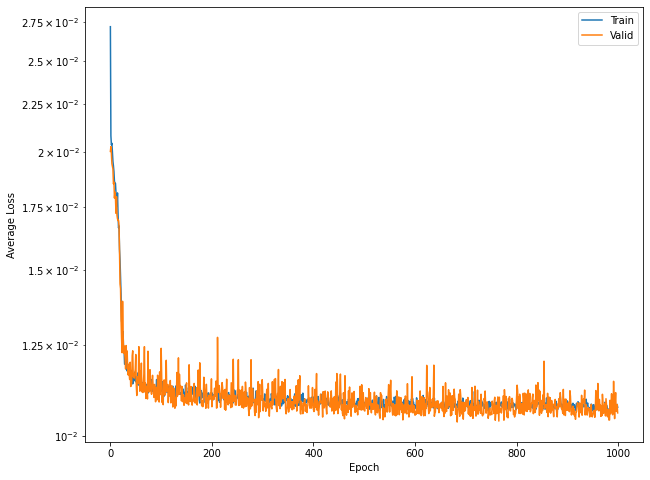

In [41]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [42]:
out_samples = []
for sample in mlp_test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples

,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.141520,0.432650,0.154634,0.13,0.486,0.15322
1,0.086285,0.055534,-0.373184,0.091,0.0708,-0.37615
2,0.061749,-0.321925,-0.229299,0.0796,-0.301,-0.27551
3,0.062843,0.361967,0.255821,0.0551,0.484,0.35095
4,0.141973,0.326124,0.343186,0.132,0.168,0.16228
...,...,...,...,...,...,...
586,0.141004,0.354263,-0.287454,0.132,0.404,-0.33317
587,0.141689,-0.306124,0.436381,0.179,-0.419,0.43766
588,0.062926,-0.178555,0.408262,0.0669,-0.213,0.45193
589,0.142941,0.159088,-0.293542,0.127,0.157,-0.17729


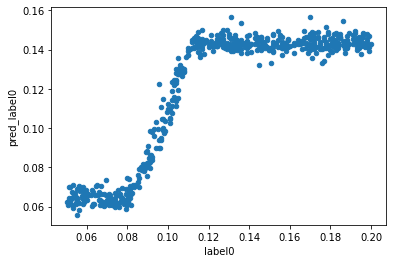

In [43]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

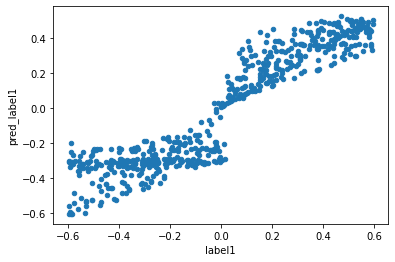

In [44]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

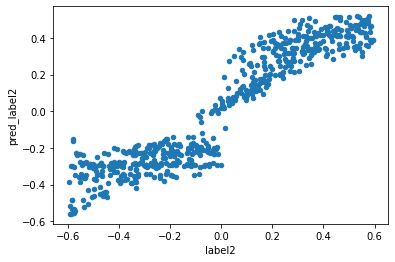

In [45]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

In [46]:
# df = df_out_samples
# fig = px.scatter(df, x="pred_label0", y="pred_label1")
# fig.show()

 

In [47]:
# df = df_out_samples
# fig = px.scatter(df, x="pred_label1", y="pred_label2")
# fig.show()


In [48]:
# df = df_out_samples
# fig = px.scatter(df, x="pred_label0", y="pred_label2")
# fig.show()


In [49]:
df_new = df_out_samples[(df_out_samples['label0'] >= 0.08) & (df_out_samples['label0'] <= 0.12)] 

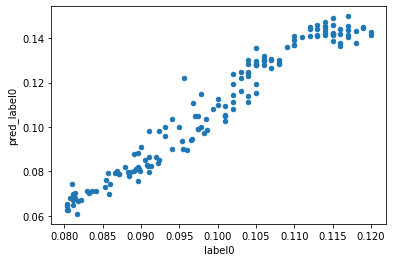

In [50]:
df_new.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

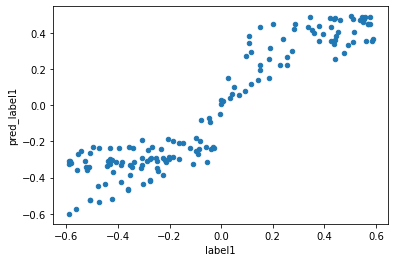

In [51]:
df_new.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

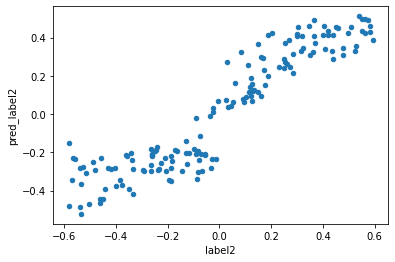

In [52]:
df_new.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

In [53]:
# df = df_new
# fig = px.scatter_3d(df, x="label0", y="label1", z="label2")
# fig.show()

In [54]:
# df = df_new
# fig = px.scatter_3d(df, x="pred_label0", y="pred_label1", z="pred_label2")
# fig.show()

In [55]:
df_new

,pred_label0,pred_label1,pred_label2,label0,label1,label2
1,0.086285,0.055534,-0.373184,0.091,0.0708,-0.37615
5,0.076280,0.492787,0.063698,0.0855,0.503,0.05279
6,0.098861,0.118556,0.453729,0.0975,0.117,0.45225
9,0.099788,-0.240980,-0.255090,0.0932,-0.0859,-0.22593
18,0.072765,-0.231648,0.431645,0.0853,-0.356,0.58341
...,...,...,...,...,...,...
578,0.069810,0.078222,-0.377202,0.0858,0.0923,-0.3995
579,0.147131,-0.314634,0.262320,0.114,-0.383,0.2617
582,0.145862,0.023975,-0.346231,0.113,0.00553,-0.19544
584,0.131157,-0.195507,-0.468445,0.106,-0.186,-0.50544


In [56]:
len(df_new)

155

In [57]:
# fig = px.histogram(df_new,x='label0')
# fig.show()

In [58]:
# fig = px.histogram(df_new,x='pred_label0')
# fig.show()

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,label0,label1,label2
0,-1.145389,0.717504,-0.056903,-0.549868,1.070564,-0.483453,1.297055,-1.539267,-0.634122,0.418666,0.116764,-0.123771,-0.563895


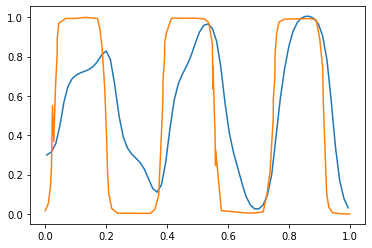

In [59]:
expt_arr_n = expt_arr[np.newaxis,:,:]
# expt_arr_n.shape

expt_labels = []

img = torch.from_numpy(expt_arr_n[0]).float()
img=torch.flatten(img).to(device)

encoder.eval().to(device)
decoder.eval().to(device)
model.eval().to(device)

with torch.no_grad():
  encoded_img  = encoder(img)
  expt_decoded_img = decoder(encoded_img)
  out_label  = model(encoder(img))

  encoded_img = encoded_img.flatten().cpu().numpy()
  out_label = out_label.cpu().numpy()

  # print(encoded_img)
  # print(out_label)
  expt_label = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}

# model.eval().to(device)
# with torch.no_grad():
#   out_label  = model(encoder(img)).cpu().numpy()

for i in range(nlabel):
    label_index = 'label'+str(i)
    expt_label[label_index] = out_label[i]

plt.plot(expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
plt.plot(expt_arr_n[0][0],expt_arr_n[0][1])

expt_labels.append(expt_label)
df_expt_labels = pd.DataFrame(expt_labels)
df_expt_labels

In [60]:
# #Plotting the joint distributions for the latent variables for the simulated sld files
# fig = plt.figure(figsize=(20, 10))
# ax = fig.add_subplot(1,1,1)
# x = df_encoded_samples['l1']
# y = df_encoded_samples['l2']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('l1')
# ax.set_ylabel('l2')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


# ax = fig.add_subplot(1,3,2)
# x = df_encoded_samples['l1']
# y = df_encoded_samples['l3']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('l1')
# ax.set_ylabel('l3')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


# ax = fig.add_subplot(1,3,3)
# x = df_encoded_samples['l2']
# y = df_encoded_samples['l3']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('l2')
# ax.set_ylabel('l3')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');

In [61]:
# #Varying l1, l2 and l3 around the values above
# x1 = expt_labels[0]['l1']
# x2 = expt_labels[0]['l2']
# # x3 = expt_labels[0]['l3']
# lv1_vals = np.linspace(x1-.5,x1+.5,100)
# lv2_vals = np.linspace(x2-.5,x2+.5,100)
# # lv3_vals = np.linspace(x3-.5,x3+.5,100)
# # lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None], lv3_vals[:, None]), axis=-1)
# lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# lv_vals = torch.from_numpy(lv_vals).float().to(device)

# #Determining the labels and the decoded images for those l1,l2,l3 above
# model.eval().to(device)
# with torch.no_grad():
#   out_label  = model(lv_vals).cpu().numpy()
# # out_label.shape

# encoder.eval().to(device)
# decoder.eval().to(device)

# with torch.no_grad():
#   decoded_img = decoder(lv_vals)

# for x in range(decoded_img.shape[0]):
#   plt.plot(decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[1])
# plt.plot(expt_arr_n[0][0],expt_arr_n[0][1],'ro',linestyle='dashed')
# plt.plot(expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1],'bo',linestyle='dashed') 

# deg_model = pd.DataFrame({'l1':lv_vals.cpu().numpy()[:,0],'l2':lv_vals.cpu().numpy()[:,1],
#                        'label0': out_label[:,0],'label1':out_label[:,1],'label2':out_label[:,2]})
# deg_model

In [62]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [63]:
# cd /content/gdrive/MyDrive

In [64]:
# PATH = '/content/gdrive/MyDrive/'
# torch.save(encoder.state_dict(), PATH + 'l2encoder.pt' )
# torch.save(decoder.state_dict(), PATH + 'l2decoder.pt' )
# torch.save(model.state_dict(), PATH + 'l2mlp.pt' )

In [65]:
# #Reloading the encoder and decoder
# encoder.load_state_dict(torch.load(PATH + 'l2encoder.pt'))
# decoder.load_state_dict(torch.load(PATH + 'l2decoder.pt'))
# model.load_state_dict(torch.load(PATH + 'l2mlp.pt'))

In [66]:
#Cut the original data to include only the region where label0 is similar to pred_label0 
cut_data_lines= []
# icont = 0
for x in range(n_params_arr.shape[0]):
  if (n_params_arr[x,0] <= 0.08 and n_params_arr[x,0] <= 0.11):
    cut_data_lines.append(x)

sld_files = []
for x in range(n_sld_arr.shape[0]):
    sld_files.append(x)   

len(sld_files), len(cut_data_lines) 

(5902, 1146)

In [67]:
#Delete the flat sld lines
myslds = [sld_id for sld_id in range(len(sld_files)) if sld_id in cut_data_lines]
len(myslds)

1146

In [68]:
c_sld_arr = n_sld_arr[myslds,:,:]
c_params_arr = n_params_arr[myslds,:]

c_sld_arr.shape, c_params_arr.shape

((1146, 2, 72), (1146, 3))

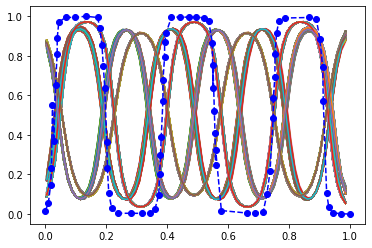

In [69]:
#Replot to make sure the flat lines are not shown
for x in range(c_sld_arr.shape[0]):
  plt.plot(c_sld_arr[x][0],c_sld_arr[x][1])
plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')